# SCAnalysis for single cell RNA-seq

This notebook details the usage of SCAnalysis for single cell RNA-seq data.

## Table of Contents

* [Introduction](#intro)
* [Loading Data](#loading)
* [Data Preprocessing](#preprocessing)
* [General Plots](#genplot)
* [Gene Set Enrichment Analysis (GSEA)](#gsea)
* [Running Wishbone](#wishbone)
* [Plotting Wishbone](#wbplot)
* [Running MAGIC](#magic)
* [Plotting MAGIC](#mgplot)

<a id="intro"></a>
## Introduction

SCAnalysis is a package for analyzing single cell data. It includes the Wishbone, MAGIC, and Palantir packages.

<a id="loading"></a>
## Loading Data

First, import the package.

In [1]:
import scanalysis

Then, you can load the data using the load function in the loadsave file of the io folder. Here, we will be using the sample_scseq_data.csv data provided in the data folder as an example.

In [2]:
df = scanalysis.io.loadsave.load("~/scanalysis/data/sample_scseq_data.csv")

Successfully loaded ~/scanalysis/data/sample_scseq_data.csv


Also, import plotting and miscellaneous

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

<a id="preprocessing"></a>
## Data preprocessing 

### Data filtering

In [ ]:
fig, ax = scanalysis.plots.plot.plot_molecules_per_cell_and_gene(df)

From these histograms, choose the appropriate cutoffs to filter the data. In this case, the data has already been filtered.

In [ ]:
# Minimum molecules/cell value
CELL_MIN = 0

# Maximum molecules/cell values
CELL_MAX = 1000000

# Minimum number of nonzero cells/gene 
# (None if no filtering desired)
GENE_NONZERO = None

# Minimum number of molecules/gene
# (None if no filtering desired)
GENE_MOLECULES = None

In [ ]:
df = scanalysis.io.preprocess.filter_scseq_data(df, filter_cell_min=CELL_MIN, filter_cell_max=CELL_MAX, 
                         filter_gene_nonzero=GENE_NONZERO, filter_gene_mols=GENE_MOLECULES)

### Data normalization

In [4]:
data = scanalysis.io.preprocess.normalize_scseq_data(df)

Successfully normalized data


### Principal Component Analysis (PCA)

The first step in data processing for Wishbone is to determine metagenes using principal component analysis. This representation is necessary to overcome the extensive dropouts that are pervasive in single cell RNA-seq data.

In [ ]:
r1, r2 = scanalysis.utils.pca.run_pca(data)

##### *Note: This sample dataset is especially sensitive, so we will be using the PCA of the original Wishbone package. (as shown below)

temp is the data after PCA is run on it.

In [ ]:
import wishbone
import os

scdata = wishbone.wb.SCData.from_csv(os.path.expanduser('~/.wishbone/data/sample_scseq_data.csv'), data_type='sc-seq', normalize=True)
scdata.run_pca()

In [ ]:
scdata.pca

In [ ]:
from copy import deepcopy
import numpy as np
import pandas as pd

n_pca_components = 5
temp = deepcopy(scdata.data)
temp -= np.min(np.ravel(temp))
temp /= np.max(np.ravel(temp))
temp = pd.DataFrame(np.dot(temp, scdata.pca['loadings'].iloc[:, 0:n_pca_components]),
                    index=scdata.data.index)

### Diffusion Maps

Diffusion maps is a non-linear dimensionality reduction technique to denoise the data and capture the major axes of variation. Diffusion maps can be determined by using the run_diffusion_map function and the diffusion components visualized on tSNE maps using plot_diffusion_components.

In [ ]:
tempEigvec, tempEigval = scanalysis.utils.diffusionmap.run_diffusion_map(temp)

### tSNE

PCA must be run separately on data before tSNE. (i.e. PCA is not included in tSNE function)

In [ ]:
t = scanalysis.utils.tsne.TSNE()
d = t.fit_transform(temp)

In [ ]:
t1 = scanalysis.utils.tsne.TSNE()
d1 = t1.fit_transform(r1)

### Saving Data **might need to revise

Data can be saved to a pickle file and loaded using the save and load functions. 

In [ ]:
scanalysis.io.loadsave.save('mouse_marrow_scdata.p')
scdata = scanalysis.io.loadsave.load('mouse_marrow_scdata.p')

<a id="genplot"></a>
## General Plots

### PCA visualization

plot_pca_variance_explained must be run without running PCA beforehand, since PCA will be run automatically by the function itself.

Results shown below for plot_pca_variance_explained_v1, which is Wishbone's version of the function.

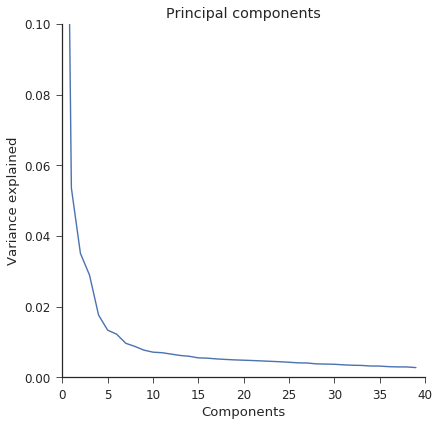

In [5]:
fig, ax = scanalysis.plots.plot.plot_pca_variance_explained_v1(data, n_components=40, random=True)

Results shown below for plot_pca_variance_explained_v2, which is MAGIC's version of the function.

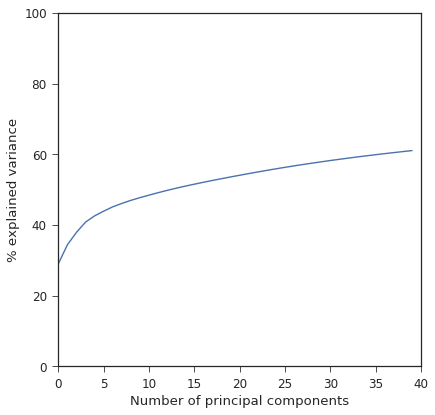

In [6]:
fig, ax = scanalysis.plots.plot.plot_pca_variance_explained_v2(data, n_components=40, random=True)

### tSNE visualization

Wishbone uses tSNE for visualization and tSNE can be run using the run_tsne function which takes the number of principal components as the parameter. From the above plot, 5 seems an appropriate number of components to use.

* how does one read a pca_variance_explained graph and choose the appropriate # of components to use?

tSNE results can be visualized by the plot_tsne and plot_tsne_by_cell_sizes functions. The plot_tsne_by_cell_sizes function colors the cells by their molecule counts before normalization.

In [ ]:
fig, ax = scanalysis.plots.plot.plot_tsne(d1)

In [ ]:
fig = plt.figure(figsize=[5, 4])
scanalysis.plots.plot.plot_tsne_by_cell_sizes(df,d1, fig = fig)

In [ ]:
fig, ax = scanalysis.plots.plot.plot_gene_expression(data, d, genes = ['CD34', 'GATA2', 'GATA1', 'MPO'])

### Diffusion map visualization

In [ ]:
fig, ax = scanalysis.plots.plot.plot_diffusion_components(d, tempEigvec, tempEigval)

Note: the component 0 is the trivial component and does not encode any information of the data.

In [ ]:
dmap_corr = scanalysis.plots.plot.run_diffusion_map_correlations(data, tempEigvec)

In [ ]:
scanalysis.plots.plot.plot_gene_component_correlations(dmap_corr)

<a id="gsea"></a>
## Gene Set Enrichment Analysis (GSEA)

The enrichments can be determined using the run_gsea function. This function needs the prefix for generating GSEA reports and a gmt file representing the different gene sets. The following invocation of the function shows the supported set of gmt files.

Please make sure to run run_diffusion_map_correlations() before running GSEA to annotate those components.

Note: The gmt files package with Wishbone/SCAnalysis assume all the gene names to be upper case. This can be ensured using the following code to convert them to upper case.

In [ ]:
data.columns = data.columns.str.upper()

In [ ]:
scanalysis.tools.wb.gsea.run_gsea(dmap_corr, output_stem= os.path.expanduser('~/.scanalysis/tools/gsea/mouse_marrow'))

Since this is data from mouse, gmt_file parameter can be set to (mouse, gofat.bp.v1.0.gmt.txt)

In [ ]:
reports = scanalysis.tools.wb.gsea.run_gsea(dmap_corr, output_stem= os.path.expanduser('~/.scanalysis/gsea/mouse_marrow'), 
                          gmt_file=('mouse', 'gofat.bp.v1.0.gmt.txt'))

The detailed reports can be found at ~/.wishbone/gsea/

In [ ]:
!open ~/.scanalysis/gsea/

run_gsea function also returns the top enrichment gene sets along each component. GSEA determines enrichments that are either positively or negatively correlated with the gene component correlations. In this dataset, components 1 and 2 show relevant enrichments and are used for running Wishbone/SCAnalysis. Please see Selection of diffusion components for single cell RNA-seq section of the Supplementary Methods for more details.

In [ ]:
# Component 1 enrichments
reports[1]['neg']

In [ ]:
# Component 2 enrichments
reports[2]['pos']

<a id="wishbone"></a>
## Running Wishbone

First, create an instance of the Wishbone class.

In [ ]:
w = scanalysis.tools.wb.wishbone.Wishbone()

After initialization, Wishbone can be run by specifying the start cell and number of waypoints to be used. The start cell for this dataset was chosen based on high expression of CD34. (for each dataset, there is a corresponding start cell particular to that dataset)

*Note: Keep in mind that Wishbone requires data that has been run through normalization, PCA, and diffusion maps.*

Here, we will consider only 2 components.(?)

In [ ]:
w.wishbone(temp1Eigvec.iloc[:,[1,2]], 'W30258', k=15, l=15, num_waypoints =250, branch=True)

<a id="wbplot"></a>
## Plotting Wishbone Results

Wishbone trajectory and branch results can be visualized on tSNE maps using the plot_wishbone_on_tsne function.

In [ ]:
scanalysis.plots.wb_plot.plot_wishbone_on_tsne(w, d)

Gene expression trends along the Wishbone trajectory can be visualized using the plot_marker_trajectory function. This function also returns the smoothed trends along with the matplotlib fig, ax handler objects.

In [ ]:
vals, fig, ax = scanalysis.plots.wb_plot.plot_marker_trajectory(scdata.data, w, ['CD34', 'GATA1', 'GATA2', 'MPO']);

The marker trends can be visualized as heatmaps in a given trajectory range using the following functions:

In [ ]:
scanalysis.plots.wb_plot.plot_marker_heatmap(w, vals)

In [ ]:
scanalysis.plots.wb_plot.plot_marker_heatmap(w, vals, trajectory_range=[0.1, 0.6])

The change in marker trends along the trajectory or derivatives can be visualized using these functions:

In [ ]:
scanalysis.plots.wb_plot.plot_derivatives(w, vals)

In [ ]:
scanalysis.plots.wb_plot.plot_derivatives(w, vals, trajectory_range=[0.3, 0.6])

<a id="magic"></a>
## Running MAGIC

MAGIC can be run with the run_magic function.

In [ ]:
new_data = scanalysis.tools.magic.run_magic(data)

#### With original MAGIC package...

In [ ]:
import magic
import os

In [ ]:
scdata = magic.mg.SCData.from_csv(os.path.expanduser('~/scanalysis/data/sample_scseq_data.csv'),data_type='sc-seq', normalize=False)

In [ ]:
scdata = scdata.normalize_scseq_data()

<a id="mgplot"></a>
## Plotting MAGIC Results

### Gene-gene scatter plots

#### 2D scatter plot before MAGIC:

In [ ]:
import warnings

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')  # catch experimental ipython widget warning
    import seaborn as sns

In [ ]:
sns.color_palette('Set1', 2)

In [ ]:
genes = ['SRRM1', 'TAB2']
plt.scatter(data[genes[0]], data[genes[1]],
                        s=8, c=data['GPX4'], edgecolors='none')

In [ ]:
import magic.magic_gui

In [ ]:
import magic

###### need to fix the color thing (can't keep calling import magic every time just to get color) 
also it doesn't work with import wishbone

In [ ]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(data, ['SRRM1', 'TAB2'], color = 'GPX4')
ax.set_xlabel('SRRM1')
ax.set_ylabel('TAB2')

You can save a figure as a png file using "savefig" as shown below.

In [ ]:
scanalysis.plots.plot.savefig(fig, 'h')

In [ ]:
new_data.head(5)

#### 2D scatter plot after MAGIC:

In [ ]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(new_data, ['MAGIC SRRM1', 'MAGIC TAB2'], color = 'MAGIC GPX4')
ax.set_xlabel('MAGIC SRRM1')
ax.set_ylabel('MAGIC TAB2')

#### 3D scatter plot before MAGIC:

In [ ]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(data, ['SRRM1', 'TAB2', 'CBR1'], color='GPX4')
ax.set_xlabel('SRRM1')
ax.set_ylabel('TAB2')
ax.set_zlabel('CBR1')

#### 3D scatter plot after MAGIC:

In [ ]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(new_data, ['MAGIC SRRM1', 'MAGIC TAB2', 'MAGIC CBR1'], color='MAGIC GPX4')
ax.set_xlabel('MAGIC SRRM1')
ax.set_ylabel('MAGIC TAB2')
ax.set_zlabel('MAGIC CBR1')

### PCA scatter plots

#### PC2 vs PC3 colored by CDH1, VIM, FN1 and ZEB1 (before MAGIC):

In [ ]:
scanalysis.plots.plot.FigureGrid(2).savefig('h')

In [ ]:
gs = gridspec.GridSpec(2,2)
fig = plt.figure(figsize=[15, 12])
genes = ['SRRM1', 'TAB2', 'CBR1', 'GPX4']
for i in range(len(genes)):
    ax = fig.add_subplot(gs[i//2, i%2])
    scanalysis.plots.plot.scatter_gene_expression(data, genes=['PC2', 'PC3'], color=genes[i], fig=fig, ax=ax)

#### PC2 vs PC3 colored by CDH1, VIM, FN1 and ZEB1 (after MAGIC):

### tSNE scatter plots

#### tSNE maps colored by CDH1, VIM, FN1, and ZEB1 (before MAGIC):

#### tSNE maps colored by CDH1, VIM, FN1, and ZEB1 (after MAGIC):

### original MAGIC package....

In [ ]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(scdata.data, ['SRRM1', 'TAB2'], color = 'GPX4')

In [ ]:
fig, ax = scdata.scatter_gene_expression(['SRRM1', 'TAB2'], color = 'GPX4')
ax.set_xlabel('SRRM1')
ax.set_ylabel('TAB2')

In [ ]:
scdata.run_magic()

In [ ]:
scdata.magic.scatter_gene_expression(['SRRM1', 'TAB2'], color = 'GPX4')

In [ ]:
fig, ax = scdata.scatter_gene_expression(['SRRM1', 'TAB2', 'CBR1'], color='GPX4')
ax.set_xlabel('SRRM1')
ax.set_ylabel('TAB2')
ax.set_zlabel('CBR1')

In [ ]:
fig, ax = scdata.magic.scatter_gene_expression(['SRRM1', 'TAB2', 'CBR1'], color='GPX4')
ax.set_xlabel('SRRM1')
ax.set_ylabel('TAB2')
ax.set_zlabel('CBR1')